In [197]:
import pandas as pd
import psycopg2 as ps
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
import plotly.graph_objs as go
from prophet import Prophet
from matplotlib.lines import Line2D
from matplotlib.dates import YearLocator, DateFormatter
from prophet.plot import plot_plotly
from prophet.plot import plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.serialize import model_to_json
from datetime import datetime
from datetime import timedelta
import warnings


warnings.filterwarnings('ignore')

In [198]:
df = pd.read_excel('assets/csv/ipeadata.xls')

In [199]:
df.head(10)

,data,preco_brent
0,20/05/1987,18.63
1,21/05/1987,18.45
2,22/05/1987,18.55
3,25/05/1987,18.60
4,26/05/1987,18.63
5,27/05/1987,18.60
6,28/05/1987,18.60
7,29/05/1987,18.58
8,01/06/1987,18.65
9,02/06/1987,18.68


In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11203 entries, 0 to 11202
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   data         11203 non-null  object 
 1   preco_brent  11203 non-null  float64
dtypes: float64(1), object(1)
memory usage: 175.2+ KB


In [201]:
df['data']= pd.to_datetime(df['data'])

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11203 entries, 0 to 11202
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   data         11203 non-null  datetime64[ns]
 1   preco_brent  11203 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 175.2 KB


In [203]:
df.isnull().sum()

data           0
preco_brent    0
dtype: int64

In [204]:
df_dados = df[['data','preco_brent']]

In [205]:
df_dados['ano'] = df['data'].dt.year
df_dados['mes'] = df['data'].dt.month
df_dados['dia'] = df['data'].dt.day

In [206]:
df_dados.head(10)

,data,preco_brent,ano,mes,dia
0,1987-05-20,18.63,1987,5,20
1,1987-05-21,18.45,1987,5,21
2,1987-05-22,18.55,1987,5,22
3,1987-05-25,18.60,1987,5,25
4,1987-05-26,18.63,1987,5,26
5,1987-05-27,18.60,1987,5,27
6,1987-05-28,18.60,1987,5,28
7,1987-05-29,18.58,1987,5,29
8,1987-06-01,18.65,1987,6,1
9,1987-06-02,18.68,1987,6,2


In [207]:
# Quais os anos analisados ?

print(f'Anos analisados:{df_dados.ano.unique()}')

Anos analisados:[1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]


In [208]:
# Maiores preços do Petroleo Brent no período total

df_sorted = df_dados.sort_values(by='preco_brent', ascending=False)
df_sorted.head()

,data,preco_brent,ano,mes,dia
6045,2008-07-07,143.95,2008,7,7
6041,2008-07-03,143.95,2008,7,3
6053,2008-07-15,143.68,2008,7,15
6056,2008-07-18,142.43,2008,7,18
6044,2008-07-06,141.24,2008,7,6


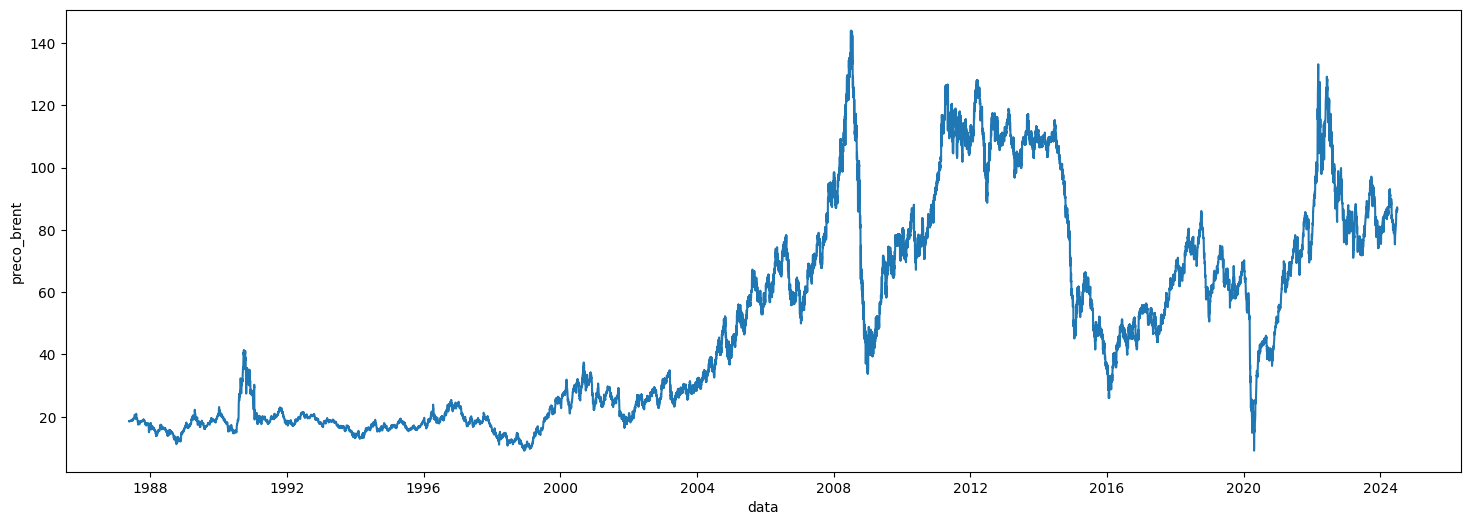

In [209]:
# Gráfico indicando a variação de preço do petróleo Brent durante todo o período

ax = sns.lineplot(data = df_dados, x='data', y='preco_brent',)
ax.figure.set_size_inches(18,6)

In [210]:
print(df)

            data  preco_brent
0     1987-05-20        18.63
1     1987-05-21        18.45
2     1987-05-22        18.55
3     1987-05-25        18.60
4     1987-05-26        18.63
...          ...          ...
11198 2024-06-25        86.81
11199 2024-06-26        85.76
11200 2024-06-27        87.00
11201 2024-06-28        87.26
11202 2024-07-01        86.57

[11203 rows x 2 columns]


In [211]:
df.nunique()

data           11203
preco_brent     5261
dtype: int64

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11203 entries, 0 to 11202
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   data         11203 non-null  datetime64[ns]
 1   preco_brent  11203 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 175.2 KB


In [213]:
# VALOR MÁXIMO REGISTRADO #

max_value = df_dados['preco_brent'].max()
print(max_value)

143.95


In [214]:
# VALOR MÍNIMO REGISTRADO #

min_value = df_dados['preco_brent'].min()
print(min_value)

9.1


In [215]:
# VALOR MÉDIO #

mean_value = df_dados['preco_brent'].mean()
print(mean_value)

53.11047844327412


In [216]:
# DESVIO PADRÃO #

desvio_padrao = df_dados['preco_brent'].std()
print(desvio_padrao)

33.21582115966959


In [217]:
# MEDIANA #

mediana = df_dados['preco_brent'].median()
print(mediana)

48.4


In [218]:
# PRIMEIRO QUARTIL 25% #

primeiro_quartil = df_dados['preco_brent'].quantile(0.25)
print(primeiro_quartil)

20.53


In [219]:
# SEGUNDO QUARTIL 50% #

segundo_quartil = df_dados['preco_brent'].quantile(0.50)
print(segundo_quartil)

48.4


In [220]:
# TERCEIRO QUARTIL 75% #

terceiro_quartil = df_dados['preco_brent'].quantile(0.75)
print(terceiro_quartil)

76.61


In [221]:
df.info()
df.columns = ['ds', 'y']
df.to_csv('assets/csv/timeseries-petroleo-brent.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11203 entries, 0 to 11202
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   data         11203 non-null  datetime64[ns]
 1   preco_brent  11203 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 175.2 KB


In [222]:
df.columns = ['data', 'preco_brent']

<Axes: xlabel='preco_brent', ylabel='Count'>

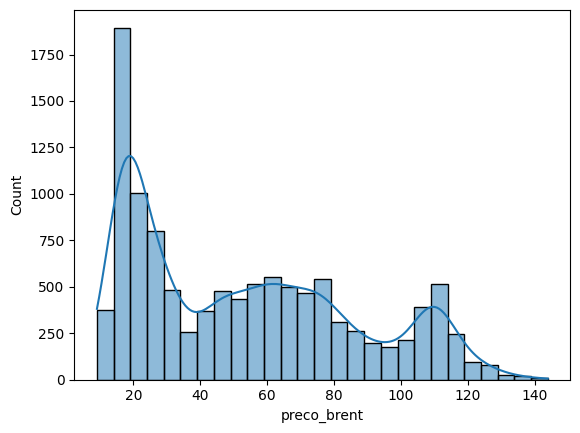

In [223]:
# GERANDO O HISTOGRAMA

sns.histplot(data=df.preco_brent, kde=True)

<Axes: ylabel='preco_brent'>

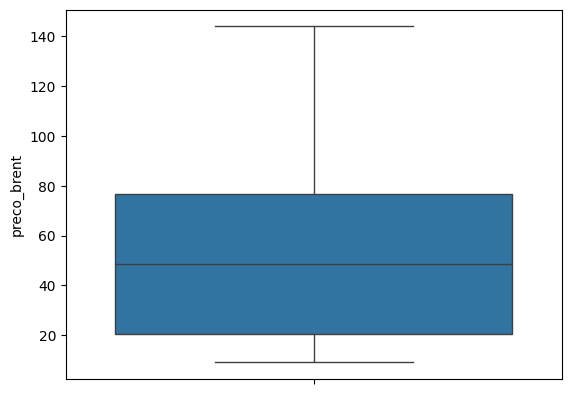

In [224]:
# GERANDO O BOXPLOT

sns.boxplot(data=df.preco_brent)

In [225]:
# CRIANDO MODELO ML

def plot_eventos(ponto: pd.Series, id_evento: int):
  if not ponto.empty:
    plt.scatter(ponto.date, float(ponto.preco_brent), s=200, facecolors='none', edgecolors='red', linewidths=2)
    plt.text(ponto.date, float(ponto.preco_brent) + 4, id_evento, ha='center', va='center', fontsize=8, fontweight='bold', color='red', bbox=dict(facecolor='white', alpha=0.4, edgecolor='red', boxstyle='round', lw=2))


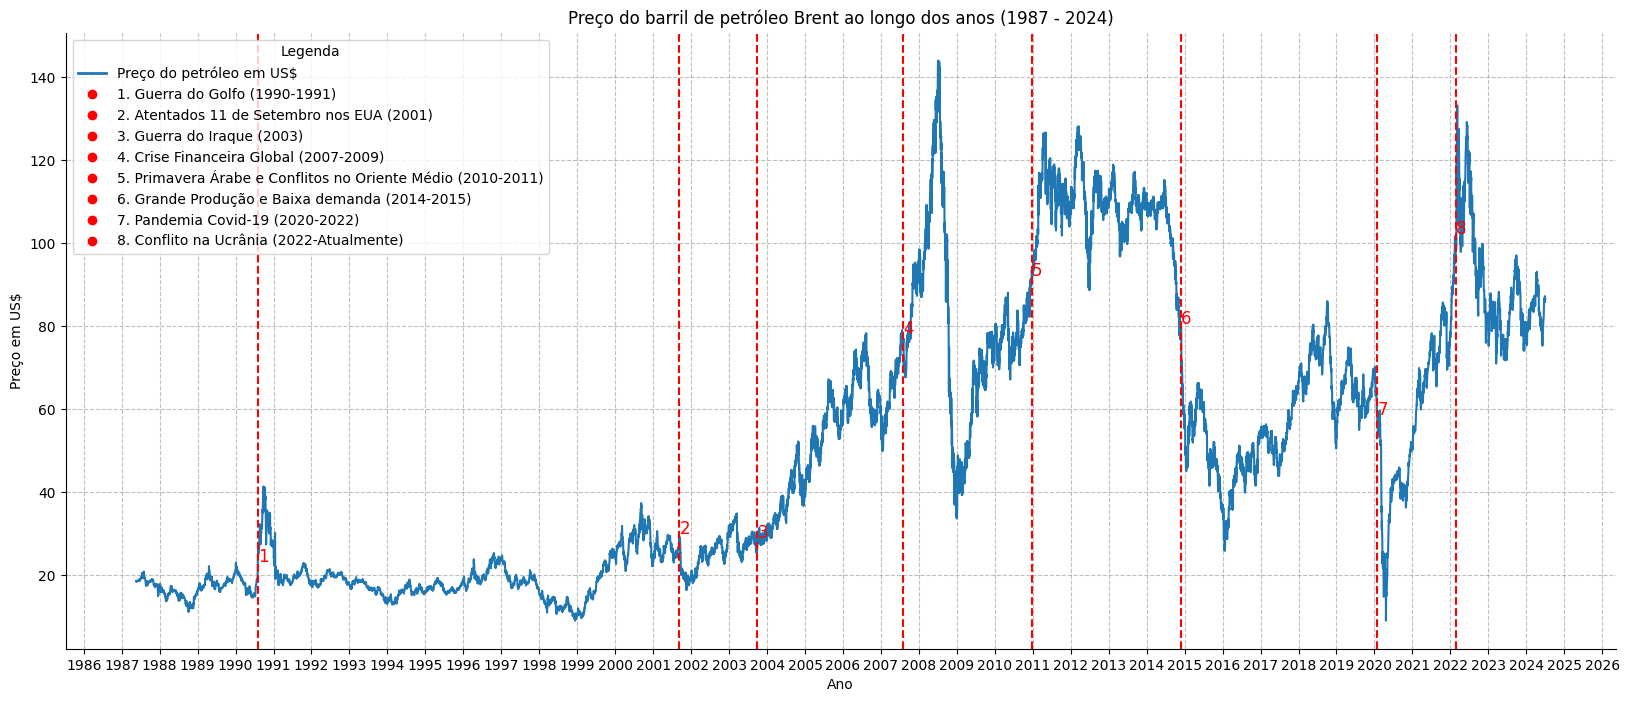

In [226]:
# CRIANDO MODELO ML

def plot_eventos(ponto: pd.Series, id_evento: int):
  if not ponto.empty:
    plt.scatter(ponto.date, float(ponto.preco_brent), s=200, facecolors='none', edgecolors='red', linewidths=2)
    plt.text(ponto.date, float(ponto.preco_brent) + 4, id_evento, ha='center', va='center', fontsize=8, fontweight='bold', color='red', bbox=dict(facecolor='white', alpha=0.4, edgecolor='red', boxstyle='round', lw=2))

# Função para configurar a legenda

def set_legenda():
    legend_handles, _ = plt.gca().get_legend_handles_labels()
    extra_labels = [
        ('Preço do petróleo em US$', '#1F77B4', 'line'),
        ('1. Guerra do Golfo (1990-1991)', 'red', 'dot'),
        ('2. Atentados 11 de Setembro nos EUA (2001)', 'red', 'dot'),
        ('3. Guerra do Iraque (2003)', 'red', 'dot'),
        ('4. Crise Financeira Global (2007-2009)', 'red', 'dot'),
        ('5. Primavera Árabe e Conflitos no Oriente Médio (2010-2011)', 'red', 'dot'),
        ('6. Grande Produção e Baixa demanda (2014-2015)', 'red', 'dot'),
        ('7. Pandemia Covid-19 (2020-2022)', 'red', 'dot'),
        ('8. Conflito na Ucrânia (2022-Atualmente)', 'red', 'dot')
    ]

    for label, color, linestyle in extra_labels:
        if linestyle == 'line':
            legend_handles.append(Line2D([0], [0], color=color, lw=2, label=label))
        elif linestyle == 'dot':
            legend_handles.append(Line2D([0], [0], color=color, marker='o', linestyle='', label=label))

    plt.legend(title='Legenda', loc='upper left', handles=legend_handles)

# Função para plotar eventos importantes
def plot_eventos(df_evento, evento_id):
    for _, row in df_evento.iterrows():
        plt.axvline(x=row['data'], color='red', linestyle='--')
        plt.text(row['data'], row['preco_brent'], str(evento_id), color='red', fontsize=12, verticalalignment='bottom')


# Configurarando o gráfico
plt.figure(figsize=(20, 8))
ax = sns.lineplot(data=df, x='data', y='preco_brent', legend=False)
ax.set_ylabel('Preço em US$')
ax.set_xlabel('Ano')
plt.gca().xaxis.set_major_locator(YearLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

# Plotar os eventos importantes
plot_eventos(df.query('data == "1990-08-02"'), 1)
plot_eventos(df.query('data == "2001-09-11"'), 2)
plot_eventos(df.query('data == "2003-10-01"'), 3)
plot_eventos(df.query('data == "2007-08-01"'), 4)
plot_eventos(df.query('data == "2010-12-20"'), 5)
plot_eventos(df.query('data == "2014-11-28"'), 6)
plot_eventos(df.query('data == "2020-01-30"'), 7)
plot_eventos(df.query('data == "2022-02-24"'), 8)

# Configurações finais do gráfico
plt.grid(linestyle='--', color='gray', alpha=0.5)
sns.despine()
set_legenda()
plt.title('Preço do barril de petróleo Brent ao longo dos anos (1987 - 2024)')
plt.show()


In [227]:
def dados_ml() -> pd.DataFrame:
  return df.query('data >= "2015-01-01"')

In [228]:
df_ml = dados_ml()
df_ml.columns = ['ds', 'y']
df_ml.head()

,ds,y
8387,2015-01-01,55.27
8388,2015-01-02,57.86
8389,2015-01-03,55.60
8390,2015-01-04,55.27
8391,2015-01-05,55.27


In [229]:
# https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning
def parametros_prophet(train_data: pd.DataFrame):
  param_grid = {
      'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
      'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
  }

  # todas combinações de parâmetros configuradas
  all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
  rmses = []

  # cross_validation para avaliar todos os parâmetros
  for params in all_params:
      m = Prophet(**params).fit(train_data)
      df_cv = cross_validation(m, horizon='30 days', parallel="processes")
      df_p = performance_metrics(df_cv, rolling_window=1)
      rmses.append(df_p['rmse'].values[0])

  # procurando os melhores hiperparâmetros
  tuning_results = pd.DataFrame(all_params)
  tuning_results['rmse'] = rmses
  print(tuning_results)

  # melhores parâmetros
  best_params = all_params[np.argmin(rmses)]
  print(best_params)

In [230]:
#parametros_prophet(df_ml)

In [231]:
# cria o modelo do prophet com os melhores hiperparâmetros
modelo = Prophet(seasonality_mode='additive', daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True, changepoint_prior_scale=0.5, seasonality_prior_scale=0.01)
modelo.add_country_holidays(country_name='BR')
modelo.fit(df_ml)

00:51:23 - cmdstanpy - INFO - Chain [1] start processing
00:51:24 - cmdstanpy - INFO - Chain [1] done processing


In [232]:
# faz a previsão dos próximos 30 dias para o preço do barril de petróleo do tipo Brent

df_futuro = modelo.make_future_dataframe(periods=30, freq='D')
previsao = modelo.predict(df_futuro)
previsao.tail(45)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Ano novo,Ano novo_lower,Ano novo_upper,Carnaval,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2801,2024-06-11,75.249508,70.784885,87.047225,75.249508,75.249508,0.0,0.0,0.0,0.0,...,0.083335,0.083335,0.083335,3.822965,3.822965,3.822965,0.0,0.0,0.0,79.155808
2802,2024-06-12,75.214242,70.920116,86.885188,75.214242,75.214242,0.0,0.0,0.0,0.0,...,-0.059385,-0.059385,-0.059385,3.853370,3.853370,3.853370,0.0,0.0,0.0,79.008228
2803,2024-06-13,75.178976,71.029584,87.380932,75.178976,75.178976,0.0,0.0,0.0,0.0,...,-0.037011,-0.037011,-0.037011,3.888443,3.888443,3.888443,0.0,0.0,0.0,79.030408
2804,2024-06-14,75.143710,71.129901,87.976035,75.143710,75.143710,0.0,0.0,0.0,0.0,...,0.084322,0.084322,0.084322,3.926816,3.926816,3.926816,0.0,0.0,0.0,79.154848
2805,2024-06-17,75.037912,71.024625,86.981032,75.037912,75.037912,0.0,0.0,0.0,0.0,...,0.216166,0.216166,0.216166,4.045687,4.045687,4.045687,0.0,0.0,0.0,79.299765
2806,2024-06-18,75.002646,71.643119,87.844839,75.002646,75.002646,0.0,0.0,0.0,0.0,...,0.083335,0.083335,0.083335,4.080786,4.080786,4.080786,0.0,0.0,0.0,79.166767
2807,2024-06-19,74.967380,71.190998,86.540311,74.967380,74.967380,0.0,0.0,0.0,0.0,...,-0.059385,-0.059385,-0.059385,4.110717,4.110717,4.110717,0.0,0.0,0.0,79.018712
2808,2024-06-20,74.932114,71.308317,86.756482,74.932114,74.932114,0.0,0.0,0.0,0.0,...,-0.037011,-0.037011,-0.037011,4.133842,4.133842,4.133842,0.0,0.0,0.0,79.028946
2809,2024-06-21,74.896848,71.204818,87.548323,74.896848,74.896848,0.0,0.0,0.0,0.0,...,0.084322,0.084322,0.084322,4.148665,4.148665,4.148665,0.0,0.0,0.0,79.129836
2810,2024-06-24,74.791050,71.607649,87.190549,74.791050,74.791050,0.0,0.0,0.0,0.0,...,0.216166,0.216166,0.216166,4.131401,4.131401,4.131401,0.0,0.0,0.0,79.138618


In [233]:
# plot dos preços históricos (desde 2015) + janela de previsão

fig = plot_plotly(modelo, previsao, trend=True, figsize=(1200, 900))

# checando as configs criadas pelo Plotly

print(fig)

linha_azul = go.Scatter(x=[2015, previsao.iloc[-1, :].ds], y=[0, 0], mode='lines', line=dict(color='blue'), name='US$ 0,00')
linha_amarela = go.Scatter(x=[2015, previsao.iloc[-1, :].ds], y=[50, 50], mode='lines', line=dict(color='gold'), name='US$ 50,00')
linha_vermelha = go.Scatter(x=[2015, previsao.iloc[-1,:].ds], y=[100, 100], mode='lines', line=dict(color='red'), name='US$ 100,00')
fig.update_layout(title='Distribuição do valor (US$) do barril de petróleo Brent entre 2015 e os dias atuais + previsão dos próximos 30 dias', showlegend=True)
fig.data[0].name = 'Realidade'
fig.data[1].name = 'Banda inferior da previsão'
fig.data[1].fill = 'tonexty'
fig.data[1].fillcolor = 'rgba(0, 114, 178, 0.2)'
fig.data[2].name = 'Previsão'
fig.data[3].name = 'Banda superior da previsão'
fig.data[4].name = 'Tendência'
fig.add_trace(linha_azul)
fig.add_trace(linha_amarela)
fig.add_trace(linha_vermelha)
fig.show()

Figure({
    'data': [{'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
              'x': array([datetime.datetime(2015, 1, 1, 0, 0),
                          datetime.datetime(2015, 1, 2, 0, 0),
                          datetime.datetime(2015, 1, 3, 0, 0), ...,
                          datetime.datetime(2024, 6, 27, 0, 0),
                          datetime.datetime(2024, 6, 28, 0, 0),
                          datetime.datetime(2024, 7, 1, 0, 0)], dtype=object),
              'y': array([55.27, 57.86, 55.6 , ..., 87.  , 87.26, 86.57])},
             {'hoverinfo': 'skip',
              'line': {'width': 0},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([datetime.datetime(2015, 1, 1, 0, 0),
                          datetime.datetime(2015, 1, 2, 0, 0),
                          datetime.datetime(2015, 1, 3, 0, 0), ...,
                          dateti

In [234]:
plot_components_plotly(modelo, previsao)

In [235]:
print(fig)

Figure({
    'data': [{'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Realidade',
              'type': 'scatter',
              'x': array([datetime.datetime(2015, 1, 1, 0, 0),
                          datetime.datetime(2015, 1, 2, 0, 0),
                          datetime.datetime(2015, 1, 3, 0, 0), ...,
                          datetime.datetime(2024, 6, 27, 0, 0),
                          datetime.datetime(2024, 6, 28, 0, 0),
                          datetime.datetime(2024, 7, 1, 0, 0)], dtype=object),
              'y': array([55.27, 57.86, 55.6 , ..., 87.  , 87.26, 86.57])},
             {'fill': 'tonexty',
              'fillcolor': 'rgba(0, 114, 178, 0.2)',
              'hoverinfo': 'skip',
              'line': {'width': 0},
              'mode': 'lines',
              'name': 'Banda inferior da previsão',
              'type': 'scatter',
              'x': array([datetime.datetime(2015, 1, 1, 0, 0),
                      

In [236]:
def calcular_mape_previsao(previsao: pd.DataFrame, train_data: pd.DataFrame):
  
  # extrair as colunas relevantes dos dataframes

  previsao_cols = ['ds', 'yhat']
  valores_reais_cols = ['ds', 'y']

  previsao = previsao[previsao_cols]
  valores_reais = train_data[valores_reais_cols]

  # merge os dataframes nas colunas 'ds' para comparar previsões e valores reais
  
  resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

  # calcula o erro percentual absoluto para cada ponto de dados
  
  resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

  # cálculo do MAPE
  
  mape = np.mean(resultados['erro_percentual_absoluto'])
  mape_decimal = np.round(mape / 100, 2)

  print(f'MAPE decimal: {mape_decimal:.2f}')
  print(f"MAPE: {mape:.8f}%")

In [237]:
calcular_mape_previsao(previsao, df_ml)


MAPE decimal: 0.08
MAPE: 8.11621280%


In [238]:
df_cv = cross_validation(modelo, horizon='120 days', parallel="processes")
df_p = performance_metrics(df_cv)
print(df_p)

     horizon         mse       rmse        mae      mape     mdape     smape  \
0    12 days  146.813785  12.116674   8.039121  0.140092  0.072929  0.126277   
1    13 days  150.893742  12.283881   8.165182  0.142639  0.073641  0.128446   
2    14 days  156.618589  12.514735   8.369809  0.146333  0.077112  0.131669   
3    15 days  161.413937  12.704878   8.559368  0.149461  0.082364  0.134551   
4    16 days  168.783656  12.991676   8.845776  0.156067  0.084592  0.139366   
..       ...         ...        ...        ...       ...       ...       ...   
104 116 days  509.484205  22.571757  17.153691  0.280612  0.208504  0.294075   
105 117 days  519.709632  22.797141  17.304162  0.282678  0.208197  0.296148   
106 118 days  525.884499  22.932172  17.388195  0.284195  0.206595  0.297950   
107 119 days  537.354072  23.180899  17.599669  0.289942  0.208251  0.303367   
108 120 days  538.414422  23.203759  17.579429  0.289285  0.207911  0.304141   

     coverage  
0    0.399403  
1    0.

EXPORTANDO O MODELO

In [239]:
# prepara o dataframe de performance
df_max_date = df_ml.ds.max()
df_p['dias_no_futuro'] = df_p['horizon'].apply(lambda horizon: int(str(horizon).split(' ')[0]))
df_p['data_no_futuro'] = df_p['dias_no_futuro'].apply(lambda dias: df_ml.ds.max() + timedelta(days=dias))
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage,dias_no_futuro,data_no_futuro
0,12 days,146.813785,12.116674,8.039121,0.140092,0.072929,0.126277,0.399403,12,2024-07-13
1,13 days,150.893742,12.283881,8.165182,0.142639,0.073641,0.128446,0.394646,13,2024-07-14
2,14 days,156.618589,12.514735,8.369809,0.146333,0.077112,0.131669,0.389053,14,2024-07-15
3,15 days,161.413937,12.704878,8.559368,0.149461,0.082364,0.134551,0.379193,15,2024-07-16
4,16 days,168.783656,12.991676,8.845776,0.156067,0.084592,0.139366,0.369737,16,2024-07-17
...,...,...,...,...,...,...,...,...,...,...
104,116 days,509.484205,22.571757,17.153691,0.280612,0.208504,0.294075,0.648452,116,2024-10-25
105,117 days,519.709632,22.797141,17.304162,0.282678,0.208197,0.296148,0.645493,117,2024-10-26
106,118 days,525.884499,22.932172,17.388195,0.284195,0.206595,0.297950,0.646776,118,2024-10-27
107,119 days,537.354072,23.180899,17.599669,0.289942,0.208251,0.303367,0.642251,119,2024-10-28


In [240]:
df_p.to_csv('assets/csv/prophet-performance.csv', index=False)

In [241]:
with open('assets/csv/prophet-model.json','w') as f_out:
    f_out.write(model_to_json(modelo))